In [1]:
%reload_ext autoreload
%autoreload 2

import os
os.environ['KERAS_BACKEND'] = 'torch'
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

import keras
from src.EEGModalNet.data.dataloader import LEMONEEGDataModule

## GAN

In [40]:
from src.EEGModalNet.models.gan import SimpleGAN
from src.EEGModalNet.data.mock_temporal_data import MockTemporalData
from src.EEGModalNet.utils import ProgressBarCallback
from tqdm.auto import tqdm

max_epochs = 10000
n_features = 10
latent_dim = 64

reusable_pbar = tqdm(total=max_epochs, unit='epoch', leave=False, dynamic_ncols=True)

# data
data = MockTemporalData(n_samples=20, n_features=n_features, n_timepoints=100)
x, _ = data()

model = SimpleGAN(time_dim=100, feature_dim=n_features, latent_dim=latent_dim)
model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True),
              d_optimizer=keras.optimizers.Adam(0.001),
              g_optimizer=keras.optimizers.Adam(0.001))

history = model.fit(
    x,
    epochs=max_epochs,
    verbose=0, # type: ignore
    shuffle=True,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor='d_loss', mode='min', patience=max_epochs // 10),
        keras.callbacks.CSVLogger('tmp/keras_logs/simple_gan_v1.csv'),
        ProgressBarCallback(n_epochs=max_epochs, n_runs=1, run_index=0, reusable_pbar=reusable_pbar),
    ]
)

  0%|          | 0/10000 [00:00<?, ?epoch/s]

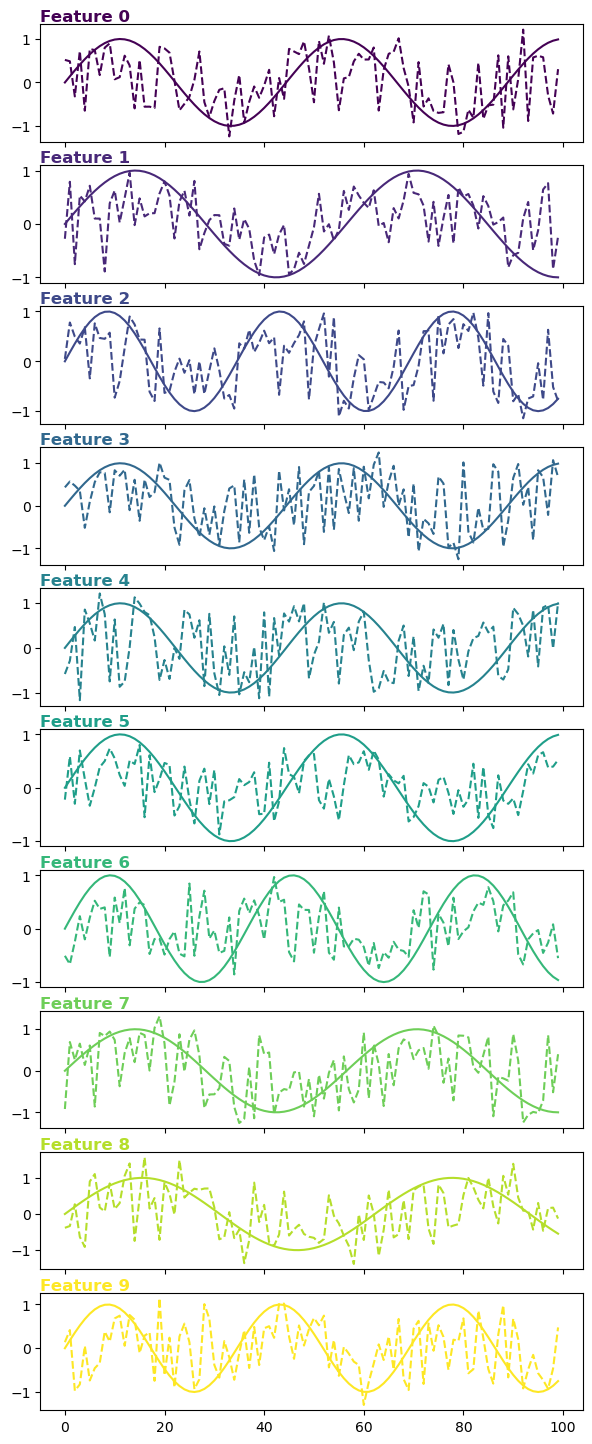

In [45]:
from matplotlib import pyplot as plt
import numpy as np
subject_to_plot = 0
feature_to_plot = range(n_features)
# pick colors based on the number of features
colors = plt.cm.viridis(np.linspace(0, 1, n_features))
# share x axis

fig, axes = plt.subplots(n_features, 1, figsize=(7, 1.8*n_features), sharex=True)
for i, (c, f) in enumerate(zip(colors, feature_to_plot)):
    axes[i].plot(x[subject_to_plot, :, f], label='real', color=c)
    noise = keras.random.normal((1, latent_dim))
    x_gen = model.generator(noise)
    axes[i].plot(x_gen[subject_to_plot, :, f].cpu().detach().numpy().squeeze(), label='generated', color=c, linestyle='--')
    axes[i].set_title(f'Feature {f}', fontsize=12, fontweight='bold', color=c, loc='left', verticalalignment='top')
plt.show()

## Load model from checkpoints

In [ ]:
from src.EEGModalNet.models import SimpleGAN
model = SimpleGAN(time_dim=100, feature_dim=1, latent_dim=64)
model.load_weights('tmp/keras_models/simple_gan_v1_HPC.model.keras')